In [90]:
import tensorflow as tf
# tensorflow_io provides extended data formats and
# the ability to stream data
import tensorflow_io as tfio
import os
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import Audio
# Import AudioSegment from pydub
from pydub import AudioSegment
from pydub.playback import play as playAudio


In [91]:
# You can use the glob module to find all .wav files in a folder and sort them based on the number of audio channels using the wave module.
# Here's an example code snippet that loads all .wav files in a folder and sorts them based on the number of audio channels:
import glob
import wave

# Define folder path
folder_path = os.getcwd()

# Find all .wav files in folder
wav_files = glob.glob(folder_path + "/*.wav")
print(".wav files in {}: {}".format(folder_path, wav_files))

# Define function to get number of channels in wav file
def get_num_channels(wav_file):
    with wave.open(wav_file, "r") as wf:
        num_channels = wf.getnchannels()
    return num_channels

mono_paths = []
stereo_paths = []

for file in wav_files:
    if get_num_channels(file) == 1:
        mono_paths.append(file)
    else:
        stereo_paths.append(file)
# Sort wav files based on number of channels
print("mono paths: {}\nstereo paths: {}".format(mono_paths, stereo_paths))

.wav files in /Users/nathan/workspace/tensor_flow_projects/audio_experiments: ['/Users/nathan/workspace/tensor_flow_projects/audio_experiments/tronica_trimmed.wav', '/Users/nathan/workspace/tensor_flow_projects/audio_experiments/2023_01_11_rocktronica_AE.wav', '/Users/nathan/workspace/tensor_flow_projects/audio_experiments/tronica_trimmed_right.wav', '/Users/nathan/workspace/tensor_flow_projects/audio_experiments/2023_01_11_rocktronica_AE_left.wav', '/Users/nathan/workspace/tensor_flow_projects/audio_experiments/tronica_trimmed_left.wav', '/Users/nathan/workspace/tensor_flow_projects/audio_experiments/2023_01_11_rocktronica_AE_right.wav']
mono paths: ['/Users/nathan/workspace/tensor_flow_projects/audio_experiments/tronica_trimmed_right.wav', '/Users/nathan/workspace/tensor_flow_projects/audio_experiments/2023_01_11_rocktronica_AE_left.wav', '/Users/nathan/workspace/tensor_flow_projects/audio_experiments/tronica_trimmed_left.wav', '/Users/nathan/workspace/tensor_flow_projects/audio_expe

## Establish our Setup Parameters

In [92]:

sample_rate = 48000
# in number of seconds
slice_length = 10
# number of samples we will use for our slices
s_len = sample_rate*slice_length
print("samples in slice: ", s_len)
audio_segments = []

# load the file and play it as a sanity check...
ittr = 0
for path in mono_paths:
      print("playing {}".format(path))
      audio_segments.append(AudioSegment.from_wav(path))
      playAudio(audio_segments[ittr][:2000])
      ittr = ittr + 1

samples in slice:  480000
playing /Users/nathan/workspace/tensor_flow_projects/audio_experiments/tronica_trimmed_right.wav
playing /Users/nathan/workspace/tensor_flow_projects/audio_experiments/2023_01_11_rocktronica_AE_left.wav
playing /Users/nathan/workspace/tensor_flow_projects/audio_experiments/tronica_trimmed_left.wav
playing /Users/nathan/workspace/tensor_flow_projects/audio_experiments/2023_01_11_rocktronica_AE_right.wav


## Generally we want to work with mono audio
 Below code will take the sample and split it into two Mono samples

In [93]:
# instead lets both load, split, and save stereo files as mono =)
def createMonoFilesFromStereo(path):
    stereo_audio = AudioSegment.from_file(
            path,
            format="wav")
    # Calling the split_to_mono method
    # on the stereo audio file
    mono_audios = stereo_audio.split_to_mono()
    
    # Exporting/Saving the two mono
    # audio files present at index 0(left)
    # and index 1(right) of list returned
    # by split_to_mono method
    left_path = path[:-4]+"_left.wav"
    right_path = path[:-4]+"_right.wav"
    print(left_path)
    print(right_path)
    mono_left = mono_audios[0].export(
        left_path,
        format="wav")
    mono_right = mono_audios[1].export(
        right_path,
        format="wav")
    return mono_left, mono_right

## It can be a good idea to both reduce the sample rate of the audio and apply a fades the sample start and end

Now we are going to create a spectrogram of our audio file...

4 faded mono tensors have been created


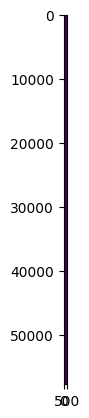

In [94]:
fft_size = 1024
window_size = 512
stride = 256

# Load audio file and cast to float32"
faded_mono_tensors = []
for path in mono_paths:
    audio_tensor, sample_rate = tf.audio.decode_wav(tf.io.read_file(path))
    audio_tensor = tf.squeeze(audio_tensor, axis=-1) # remove channel dimension
    audio_tensor = tf.cast(audio_tensor, tf.float32) / 32768.0
    faded_tensor = tfio.audio.fade(audio_tensor, fade_in=100, fade_out=100, mode='logarithmic')
    faded_mono_tensors.append(faded_tensor)

# Apply fade in and fade out
print("{} faded mono tensors have been created".format(len(faded_mono_tensors)))

spectrogram = tfio.audio.spectrogram(
    faded_mono_tensors[1], nfft=fft_size, window=window_size, stride=stride)

# derr there is something wrong with how this displays....
plt.figure()
plt.imshow(spectrogram.numpy())
# plt.specgram(spectrogram[0], NFFT=fft_size, window=window_size)
# remove an extra single dimension axis,
# I am not sure where it comes from...
# squeezed_spectrogram = tf.squeeze(tf.math.log(spectrogram).numpy(), axis=[-2])
# print(squeezed_spectrogram.shape)

In [95]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Load audio file
audio_binary = tf.io.read_file(mono_paths[0])
audio_tensor, sample_rate = tf.audio.decode_wav(audio_binary)

# Compute spectrogram
s = tf.abs(tf.signal.stft(audio_tensor, frame_length=2048, frame_step=512, fft_length=2048))
print("Computed spectrogram of type {} and shape of {}, we need to get rid of the middle dimension".format(type(s), s.shape))


mask = tf.reduce_sum(s, axis=-1) != 0

if tf.reduce_all(mask):
    ss = tf.reshape(s, (s.shape[0], s.shape[2]))
else:
    ss = tf.boolean_mask(s, mask, axis=1)

print("Final spectrogram of type {} and shape of {}".format(type(ss), ss.shape))

Computed spectrogram of type <class 'tensorflow.python.framework.ops.EagerTensor'> and shape of (2425819, 0, 1025), we need to get rid of the middle dimension


InvalidArgumentError: {{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input to reshape is a tensor with 0 values, but the requested shape has 2486464475 [Op:Reshape]

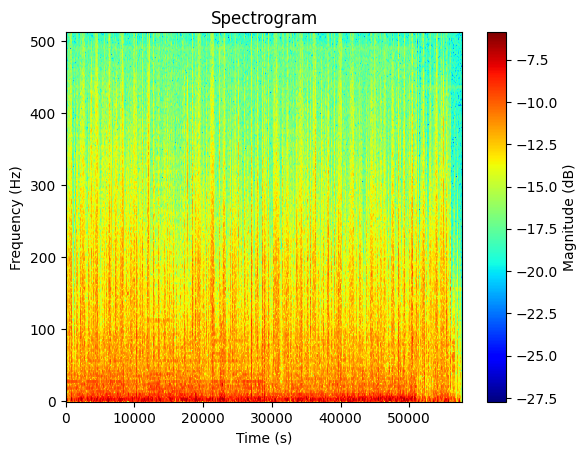

In [98]:
# Plot spectrogram
fig, ax = plt.subplots()
im = ax.imshow(tf.math.log(spectrogram).numpy().T, aspect="auto", origin="lower",
               cmap="jet", interpolation="none")

# Set axis labels and title
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Spectrogram")

# Set colorbar
cbar = fig.colorbar(im)
cbar.ax.set_ylabel("Magnitude (dB)")

# Show plot
plt.show()

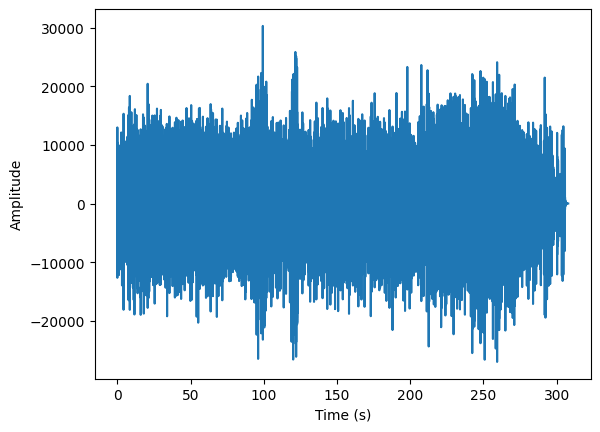

In [100]:
import wave
import numpy as np
import matplotlib.pyplot as plt

# Open the audio file
with wave.open(mono_paths[1], "rb") as wave_file:
    # Get the audio data
    frame_rate = wave_file.getframerate()
    num_frames = wave_file.getnframes()
    num_channels = wave_file.getnchannels()
    sample_width = wave_file.getsampwidth()
    audio_data = wave_file.readframes(num_frames)

# Convert the audio data to a NumPy array
audio_array = np.frombuffer(audio_data, dtype=np.int16)

# Reshape the array to match the number of channels
if num_channels > 1:
    audio_array = np.reshape(audio_array, (-1, num_channels))

# Compute the duration of the audio file in seconds
duration = num_frames / frame_rate

# Create a time axis for the waveform
time_axis = np.linspace(0, duration, num=num_frames)

# Plot the waveform
plt.plot(time_axis, audio_array)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

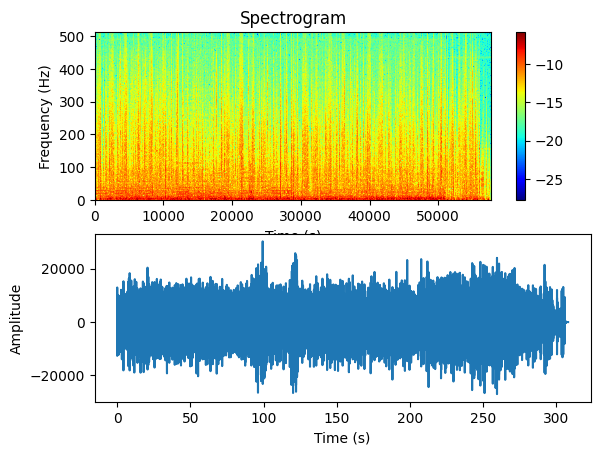

In [107]:
# Plot spectrogram
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False)
im = ax[0].imshow(tf.math.log(spectrogram).numpy().T, aspect="auto", origin="lower",
               cmap="jet", interpolation="none")

# Set axis labels and title
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("Frequency (Hz)")
ax[0].set_title("Spectrogram")

# Set colorbar
cbar = fig.colorbar(im)
# cbar.label("Magnitude (dB)")

# Plot the waveform
ax[1].plot(time_axis, audio_array)
ax[1].set_xlabel("Time (s)")
ax[1].set_ylabel("Amplitude")

# Show plot
plt.show()

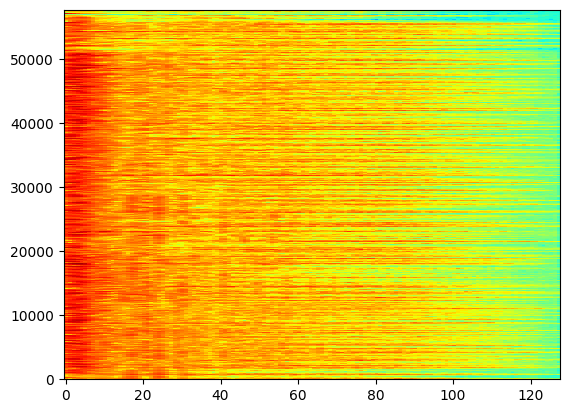

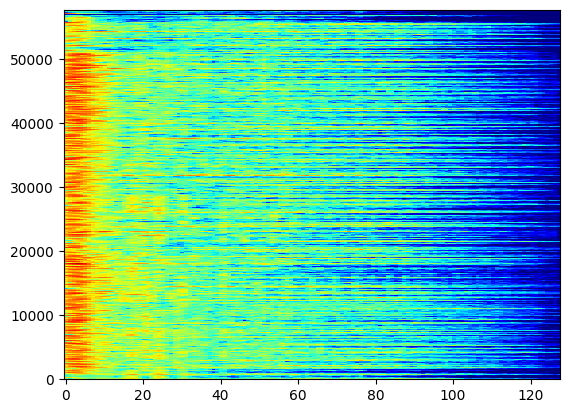

In [109]:
# Convert to mel-spectrogram
mel_spectrogram = tfio.audio.melscale(
    spectrogram, rate=16000, mels=128, fmin=0, fmax=8000)


plt.figure()
plt.imshow(tf.math.log(mel_spectrogram).numpy(), aspect="auto", origin="lower",
               cmap="jet", interpolation="none")

# Convert to db scale mel-spectrogram
dbscale_mel_spectrogram = tfio.audio.dbscale(
    mel_spectrogram, top_db=80)

plt.figure()
plt.imshow(dbscale_mel_spectrogram.numpy(), aspect="auto", origin="lower",
               cmap="jet", interpolation="none")

Frequency Masking
In frequency masking, frequency channels [f0, f0 + f) are masked where f is chosen from a uniform distribution from 0 to the frequency mask parameter F, and f0 is chosen from (0, ν − f) where ν is the number of frequency channels.

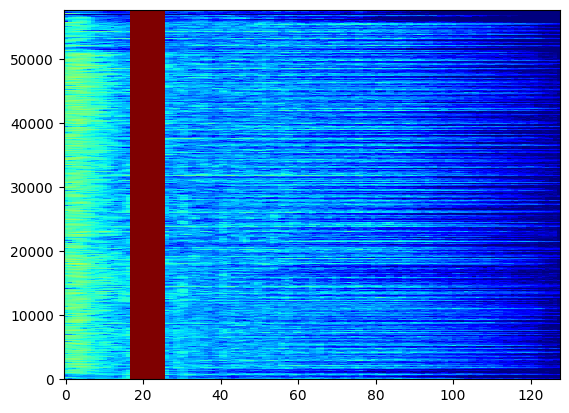

In [119]:
# Freq masking
freq_mask = tfio.audio.freq_mask(dbscale_mel_spectrogram, param=15)

plt.figure()
plt.imshow(freq_mask.numpy(), aspect="auto", origin="lower",
               cmap="jet", interpolation="none")

Time Masking
In time masking, t consecutive time steps [t0, t0 + t) are masked where t is chosen from a uniform distribution from 0 to the time mask parameter T, and t0 is chosen from [0, τ − t) where τ is the time steps.

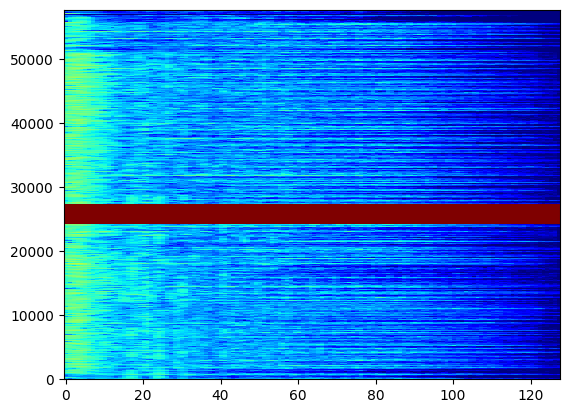

In [115]:
# Time masking
time_mask = tfio.audio.time_mask(dbscale_mel_spectrogram, param=10000)

plt.figure()
plt.imshow(time_mask.numpy(), aspect="auto", origin="lower",
               cmap="jet", interpolation="none")

In [123]:
import tensorflow as tf
import librosa
import numpy as np

# Load the pre-trained VGGish model
model = tf.keras.models.load_model('path/to/pretrained/model')

# Load and preprocess the audio file
audio_file = '/Users/nathan/workspace/tensor_flow_projects/audio_experiments/2023_01_11_rocktronica_AE.wav'
audio_data, sr = librosa.load(audio_file, sr=16000, mono=True)
mfccs = librosa.feature.mfcc(y=audio_data, sr=sr, n_mfcc=13)
mfccs = np.mean(mfccs.T, axis=0)
mfccs = np.expand_dims(mfccs, axis=0)

# Classify the audio file
predictions = model.predict(mfccs)
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
predicted_genre = genres[np.argmax(predictions)]
print('Predicted genre:', predicted_genre)

OSError: No file or directory found at path/to/pretrained/model

In [125]:
import vggish_keras as vgk
# loads the model once and provides a simple function that takes in `filename` or `y, sr`
compute = vgk.get_embedding_function(hop_duration=0.25)
# model, pump, and sampler are available as attributes
compute.model.summary() # take a peak at the model

# compute from filename
Z, ts = compute(librosa.util.example_audio_file())

# compute from pcm
y, sr = librosa.load(librosa.util.example_audio_file())
Z, ts = compute(y=y, sr=sr)

ModuleNotFoundError: No module named 'vggish_keras'